<h1>Анализ предметной области на основе базы статей из Web of Science</h1>

In [1]:
# импорт необходимых модулей
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import matplotlib.pyplot as plt
%matplotlib inline
#import mpld3

In [2]:
# Загрузка файлов и информацией о статьях
# эти файлы были предварительно выгружены с WoS
df = pd.read_csv('cit libration 1.txt', sep='\t', index_col=False)
df2 = pd.read_csv('cit libration 2.txt', sep='\t', index_col=False)
df3 = pd.read_csv('cit libration 2.txt', sep='\t', index_col=False)
df = pd.concat([df, df2, df3])

In [3]:
# для удобства работы, оставляю только колонки с названием и абстрактом
df = df[['TI', 'AB']]
df = df.dropna()
df.shape

(1477, 2)

In [4]:
title = [i for i in df['TI']]
abstracts = [i for i in df['AB']]

In [5]:
# импорт стоп-слов из модуля nltk (Natural Language Toolkit )
stopwords = nltk.corpus.stopwords.words('english')
# добавляю свои стоп-слова
stopwords.extend(['publish', 'elsevi', 'ltd', 'c', 'b.v', 'inc.', 'right', 'iaa', 'x', 'cospar', 'e', 'e.g.', 'masson', 'sas', 'et', 'al', 'h', 'i.e',\
'j', 'k', 'l'])

In [6]:
# Stemmer по слову возращает корнеь
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [7]:
# Функции, которые разбивают текст на словаи из этих слов получают корни

def tokenize_and_stem(text):
    text = text.replace("'", ' ').replace("-",' ').replace('/', ' ')
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]{2,}', token):
            if not token in stopwords:
                filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    text = text.replace("'", ' ').replace("-",' ').replace('/', ' ')
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]{2,}', token):
            if not token in stopwords:
                filtered_tokens.append(token)
    return filtered_tokens

In [8]:
# обработка всех абстрактов
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in abstracts:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)
    #totalvocab_stemmed.extend([stemmer.stem(t) for t in allwords_tokenized])

In [9]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 151535 items in vocab_frame


<h2>Расчет матрицы TF-IDF</h2>

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [11]:
# расчет матрицы tf-ifd
tfidf_vectorizer = TfidfVectorizer(max_df=0.99, max_features=200000,
                                 min_df=0.01, stop_words=stopwords,#stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,5))

tfidf_matrix = tfidf_vectorizer.fit_transform(abstracts) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

(1477, 1852)


In [12]:
terms = tfidf_vectorizer.get_feature_names()

In [13]:
# расчет расстояний между текстами
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)
dist.shape

(1477, 1477)

<h2> Кластеризация методом К-средних</h2>

In [14]:
from sklearn.cluster import KMeans
num_clusters = 6
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

In [15]:
print("Top terms per cluster:")

#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
cluster_names = {}

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    cluster_names[i] = []
    for ind in order_centroids[i, :8]: #replace 6 with n words per cluster
        #cluster_names[i].append(vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0])
        cluster_names[i].append(terms[ind])
        #print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
        print(' %s' % terms[ind].encode('utf-8', 'ignore'), end=',')
    print()


Top terms per cluster:
Cluster 0 words: b'mission', b'orbit', b'earth', b'space', b'lunar', b'moon', b'spacecraft', b'design',
Cluster 1 words: b'stabil', b'mass', b'bodi', b'primari', b'point', b'problem', b'oblat', b'triangular',
Cluster 2 words: b'reson', b'orbit', b'period', b'librat', b'observ', b'frequenc', b'motion', b'model',
Cluster 3 words: b'tether', b'control', b'system', b'plane', b'satellit', b'motion', b'dynam', b'orbit',
Cluster 4 words: b'control', b'format', b'orbit', b'spacecraft', b'optim', b'use', b'system', b'method',
Cluster 5 words: b'transfer', b'orbit', b'manifold', b'trajectori', b'invari', b'invari manifold', b'earth', b'moon',


In [16]:
for k in cluster_names:
    print(k, ', '.join(cluster_names[k][:-1]))

0 mission, orbit, earth, space, lunar, moon, spacecraft
1 stabil, mass, bodi, primari, point, problem, oblat
2 reson, orbit, period, librat, observ, frequenc, motion
3 tether, control, system, plane, satellit, motion, dynam
4 control, format, orbit, spacecraft, optim, use, system
5 transfer, orbit, manifold, trajectori, invari, invari manifold, earth


<h2>Визуализация результатов</h2>
Требуется метод Multi-dimensional scaling, потому что абстракт-это вектор,который имеет 1477 компонент. MDS позволит спроецировать эти вектора на плоскость, сохраняя расстояния между ними.

In [17]:
from sklearn.manifold import MDS

MDS()

MDS(dissimilarity='euclidean', eps=0.001, max_iter=300, metric=True,
  n_components=2, n_init=4, n_jobs=1, random_state=None, verbose=0)

In [18]:
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=10)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
xs, ys = pos[:, 0], pos[:, 1]

In [19]:
cluster_colors = {0:'#2d519a', 1:'#0084cd', 2:'#79a6c5',3:'#ffe15e', 4:'#37c5ee', 5:'#f47f20', 6:'#ee392c',\
                  7:'#70be44', 8:'#80be44', 9:'#c3a3cd'}

In [20]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=title)) 
#group by cluster
groups = df.groupby('label')

0
1
2
3
4
5


(-0.8884374176173111,
 0.88714711263837986,
 -0.87602222957503939,
 0.87089614733399501)

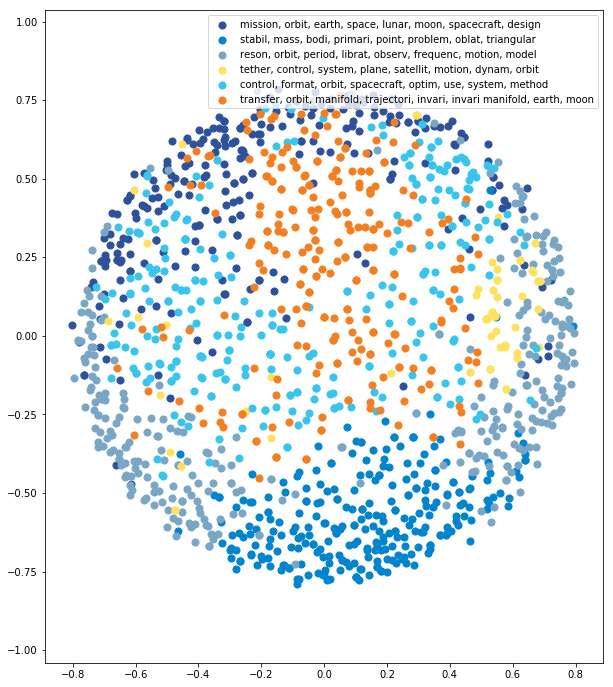

In [21]:
f = plt.gcf()
f.set_size_inches((10,12))
for name, group in groups: 
    print(name)
    plt.scatter(group.x, group.y, s=50, c=cluster_colors[name], label=', '.join(cluster_names[name]))
plt.legend(loc=1)
plt.axis('equal')
#plt.savefig('clusters abstracts.png', dpi=200)                

Другой способ отрисовки, с помощью plotly, при наведении на точку будет всплывать название статьи

In [ ]:
import plotly.plotly as py
import plotly.graph_objs as go

In [ ]:
data = [
    go.Scatter(
        x=xs,
        y=ys,
        mode='markers',
        text=title
    )
]
layout = go.Layout(
    title='Hover over the points to see the text'
)
fig = go.Figure(data=data, layout=layout)
plot_url = py.plot(fig, filename='hover-chart-basic')

In [25]:
data = []
for name, group in groups:
    data.append(
        go.Scatter(
        x=group.x,
        y=group.y,
        #hoverinfo="x+y",
        mode='markers',
        marker = dict(
        size=20,
        color=cluster_colors[name]),
        text=group.title,#' '.join([str(group.x), str(group.y)]),#group.title,#
        name=' '.join(cluster_names[name])#group.title
    ))
    #print(group.title)
    #print(cluster_names[name])
    
layout = go.Layout(
    title='abstracts',
    hovermode='closest',
    yaxis={'range':[-1,1]}
)
fig = go.Figure(data=data, layout=layout)
plot_url = py.plot(fig, filename='hover-chart-basic')